In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from utils.utils import load_data, remove_zero_features, standardize
from utils.utils import generate_oversampled_set, generate_undersampled_set, generate_label_stats
from utils.utils import compute_scores_binary, compute_auprc_auroc_scores
from utils.plot_utils import plot_pr_curves, plot_roc_curves

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [3]:
plot_path = 'plots/'

In [4]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 8


---

In [5]:
# Load data for classification task
subject_data, features, diagnoses = load_data('classification')

In [6]:
# Remove zero features
F = remove_zero_features(features.iloc[:,1:])

In [7]:
# Standardize
X = standardize(F)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Number of samples: 2815
Number of features: 922


In [8]:
# Remove ID column
Y = diagnoses.iloc[:,1:]
print(f"Number of labels: {Y.shape[1]}")

Number of labels: 13


In [9]:
boot_iter = 100

---

# 1. Use dataset with original label distribution (no resampling)

In [10]:
label_stats, mean_ir = generate_label_stats(Y, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 7.995236107963529


,Absolute frequency,Relative frequency,Imbalance ratio,Within-label imbalance
Trauma_And_Stress_RelatedDisorders,152,0.053996,11.519737,0.053996
DepressiveDisorders,300,0.106572,5.836667,0.106572
Attention_Deficit_HyperactivityDisorder,1751,0.622025,1.000000,0.622025
MotorDisorder,229,0.081350,7.646288,0.081350
AutismSpectrumDisorder,398,0.141385,4.399497,0.141385
CommunicationDisorder,493,0.175133,3.551724,0.175133
OtherDisorders,135,0.047957,12.970370,0.047957
SpecificLearningDisorder,761,0.270337,2.300920,0.270337
Obsessive_Compulsive_And_RelatedDisorders,137,0.048668,12.781022,0.048668
Disruptive,436,0.154885,4.016055,0.154885


In [11]:
# Split dataset into train and test (holdout) set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 2111
Number of samples in test set: 704


## 1.1. Logistic regression

In [12]:
lr_1_estimators = {}

p_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', max_iter=10000, random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [13]:
'''
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    lr_1_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")
'''

'\n# Perform grid search for every label\nfor l, label in enumerate(Y.columns):\n    y_train = Y_train.iloc[:, l]\n    gs.fit(X_train, np.ravel(y_train))\n\n    lr_1_estimators[label] = gs\n    print(f"{label}: {gs.best_params_}")\n'

In [14]:
# Hardcoded optimal params
param_dict = {
    'Trauma_And_Stress_RelatedDisorders': {'C': 0.0001},
    'DepressiveDisorders': {'C': 0.0001},
    'Attention_Deficit_HyperactivityDisorder': {'C': 0.0001},
    'MotorDisorder': {'C': 0.0001},
    'AutismSpectrumDisorder': {'C': 0.0001},
    'CommunicationDisorder': {'C': 0.0001},
    'OtherDisorders': {'C': 0.0001},
    'SpecificLearningDisorder': {'C': 0.001},
    'Obsessive_Compulsive_And_RelatedDisorders': {'C': 0.001},
    'Disruptive': {'C': 0.0001},
    'IntellectualDisability': {'C': 0.001},
    'EliminationDisorder': {'C': 0.0001},
    'AnxietyDisorders': {'C': 0.0001},
}

In [15]:
lr_1_estimators = {}

for k,v in param_dict.items():
    lr_1_estimators[k] = LogisticRegression(max_iter=10000, n_jobs=-1, C=v['C'] , random_state=0).fit(X_train, Y_train[k])

In [16]:
compute_auprc_auroc_scores(lr_1_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

AUPRC:
Trauma_And_Stress_RelatedDisorders:               0.08 (0.02) [0.05, 0.12]
DepressiveDisorders:                              0.33 (0.05) [0.25, 0.42]
Attention_Deficit_HyperactivityDisorder:          0.69 (0.02) [0.65, 0.73]
MotorDisorder:                                    0.15 (0.03) [0.10, 0.19]
AutismSpectrumDisorder:                           0.18 (0.02) [0.14, 0.24]
CommunicationDisorder:                            0.23 (0.03) [0.18, 0.29]
OtherDisorders:                                   0.17 (0.05) [0.06, 0.27]
SpecificLearningDisorder:                         0.30 (0.02) [0.25, 0.34]
Obsessive_Compulsive_And_RelatedDisorders:        0.14 (0.04) [0.08, 0.24]
Disruptive:                                       0.18 (0.02) [0.14, 0.24]
IntellectualDisability:                           0.12 (0.07) [0.04, 0.28]
EliminationDisorder:                              0.13 (0.02) [0.09, 0.17]
AnxietyDisorders:                         

In [17]:
compute_scores_binary(lr_1_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.24 (0.01) [0.23, 0.27]
auprc_weighted:               0.39 (0.01) [0.37, 0.41]
auroc_macro:                  0.61 (0.01) [0.59, 0.63]
auroc_weighted:               0.60 (0.01) [0.58, 0.62]
brier_macro:                  0.11 (0.00) [0.11, 0.12]
brier_weighted:               0.03 (0.00) [0.03, 0.03]
balanced_accuracy_macro:      0.50 (0.00) [0.50, 0.50]
balanced_accuracy_weighted:   0.08 (0.00) [0.08, 0.08]
f1_micro:                     0.38 (0.01) [0.37, 0.40]
hamming:                      0.15 (0.00) [0.14, 0.16]
subset_accuracy:              0.10 (0.01) [0.08, 0.12]


## 1.2. Histogram-based Gradient Boosting

In [18]:
hgb_1_estimators = {}

p_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [100, 200] ,
    "l2_regularization": [0.001, 0.01, 0.1],
}

gs = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [19]:
'''
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    hgb_1_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")
'''

'\n# Perform grid search for every label\nfor l, label in enumerate(Y.columns):\n    y_train = Y_train.iloc[:, l]\n    gs.fit(X_train, np.ravel(y_train))\n\n    hgb_1_estimators[label] = gs\n    print(f"{label}: {gs.best_params_}")\n'

In [20]:
# Hardcoded optimal params
param_dict = {
    'Trauma_And_Stress_RelatedDisorders': {'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_iter': 200},
    'DepressiveDisorders': {'l2_regularization': 0.01, 'learning_rate': 0.05, 'max_iter': 100},
    'Attention_Deficit_HyperactivityDisorder': {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 200},
    'MotorDisorder': {'l2_regularization': 0.001, 'learning_rate': 0.1, 'max_iter': 100},
    'AutismSpectrumDisorder': {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 100},
    'CommunicationDisorder': {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 100},
    'OtherDisorders': {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 100},
    'SpecificLearningDisorder': {'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_iter': 200},
    'Obsessive_Compulsive_And_RelatedDisorders': {'l2_regularization': 0.001, 'learning_rate': 0.01, 'max_iter': 200},
    'Disruptive': {'l2_regularization': 0.001, 'learning_rate': 0.01, 'max_iter': 100},
    'IntellectualDisability': {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 200},
    'EliminationDisorder': {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 100},
    'AnxietyDisorders': {'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_iter': 200},
}

In [21]:
hgb_1_estimators = {}

for k,v in param_dict.items():
    hgb_1_estimators[k] = HistGradientBoostingClassifier(random_state=0, l2_regularization=v['l2_regularization'], learning_rate=v['learning_rate'], max_iter=v['max_iter']).fit(X_train, Y_train[k])

In [22]:
compute_auprc_auroc_scores(hgb_1_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

AUPRC:
Trauma_And_Stress_RelatedDisorders:               0.10 (0.03) [0.06, 0.17]
DepressiveDisorders:                              0.34 (0.05) [0.24, 0.45]
Attention_Deficit_HyperactivityDisorder:          0.65 (0.03) [0.60, 0.69]
MotorDisorder:                                    0.11 (0.02) [0.08, 0.15]
AutismSpectrumDisorder:                           0.18 (0.02) [0.14, 0.23]
CommunicationDisorder:                            0.21 (0.03) [0.16, 0.27]
OtherDisorders:                                   0.17 (0.05) [0.08, 0.27]
SpecificLearningDisorder:                         0.30 (0.03) [0.26, 0.37]
Obsessive_Compulsive_And_RelatedDisorders:        0.10 (0.02) [0.06, 0.14]
Disruptive:                                       0.20 (0.03) [0.15, 0.26]
IntellectualDisability:                           0.11 (0.07) [0.02, 0.28]
EliminationDisorder:                              0.18 (0.04) [0.12, 0.26]
AnxietyDisorders:                         

In [23]:
compute_scores_binary(hgb_1_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.24 (0.01) [0.22, 0.26]
auprc_weighted:               0.37 (0.01) [0.35, 0.40]
auroc_macro:                  0.59 (0.01) [0.57, 0.62]
auroc_weighted:               0.57 (0.01) [0.55, 0.59]
brier_macro:                  0.12 (0.00) [0.11, 0.12]
brier_weighted:               0.03 (0.00) [0.03, 0.03]
balanced_accuracy_macro:      0.51 (0.00) [0.50, 0.51]
balanced_accuracy_weighted:   0.09 (0.00) [0.08, 0.09]
f1_micro:                     0.36 (0.01) [0.34, 0.38]
hamming:                      0.15 (0.00) [0.14, 0.16]
subset_accuracy:              0.12 (0.01) [0.10, 0.14]


# 2. Plot PR and AUROC curve

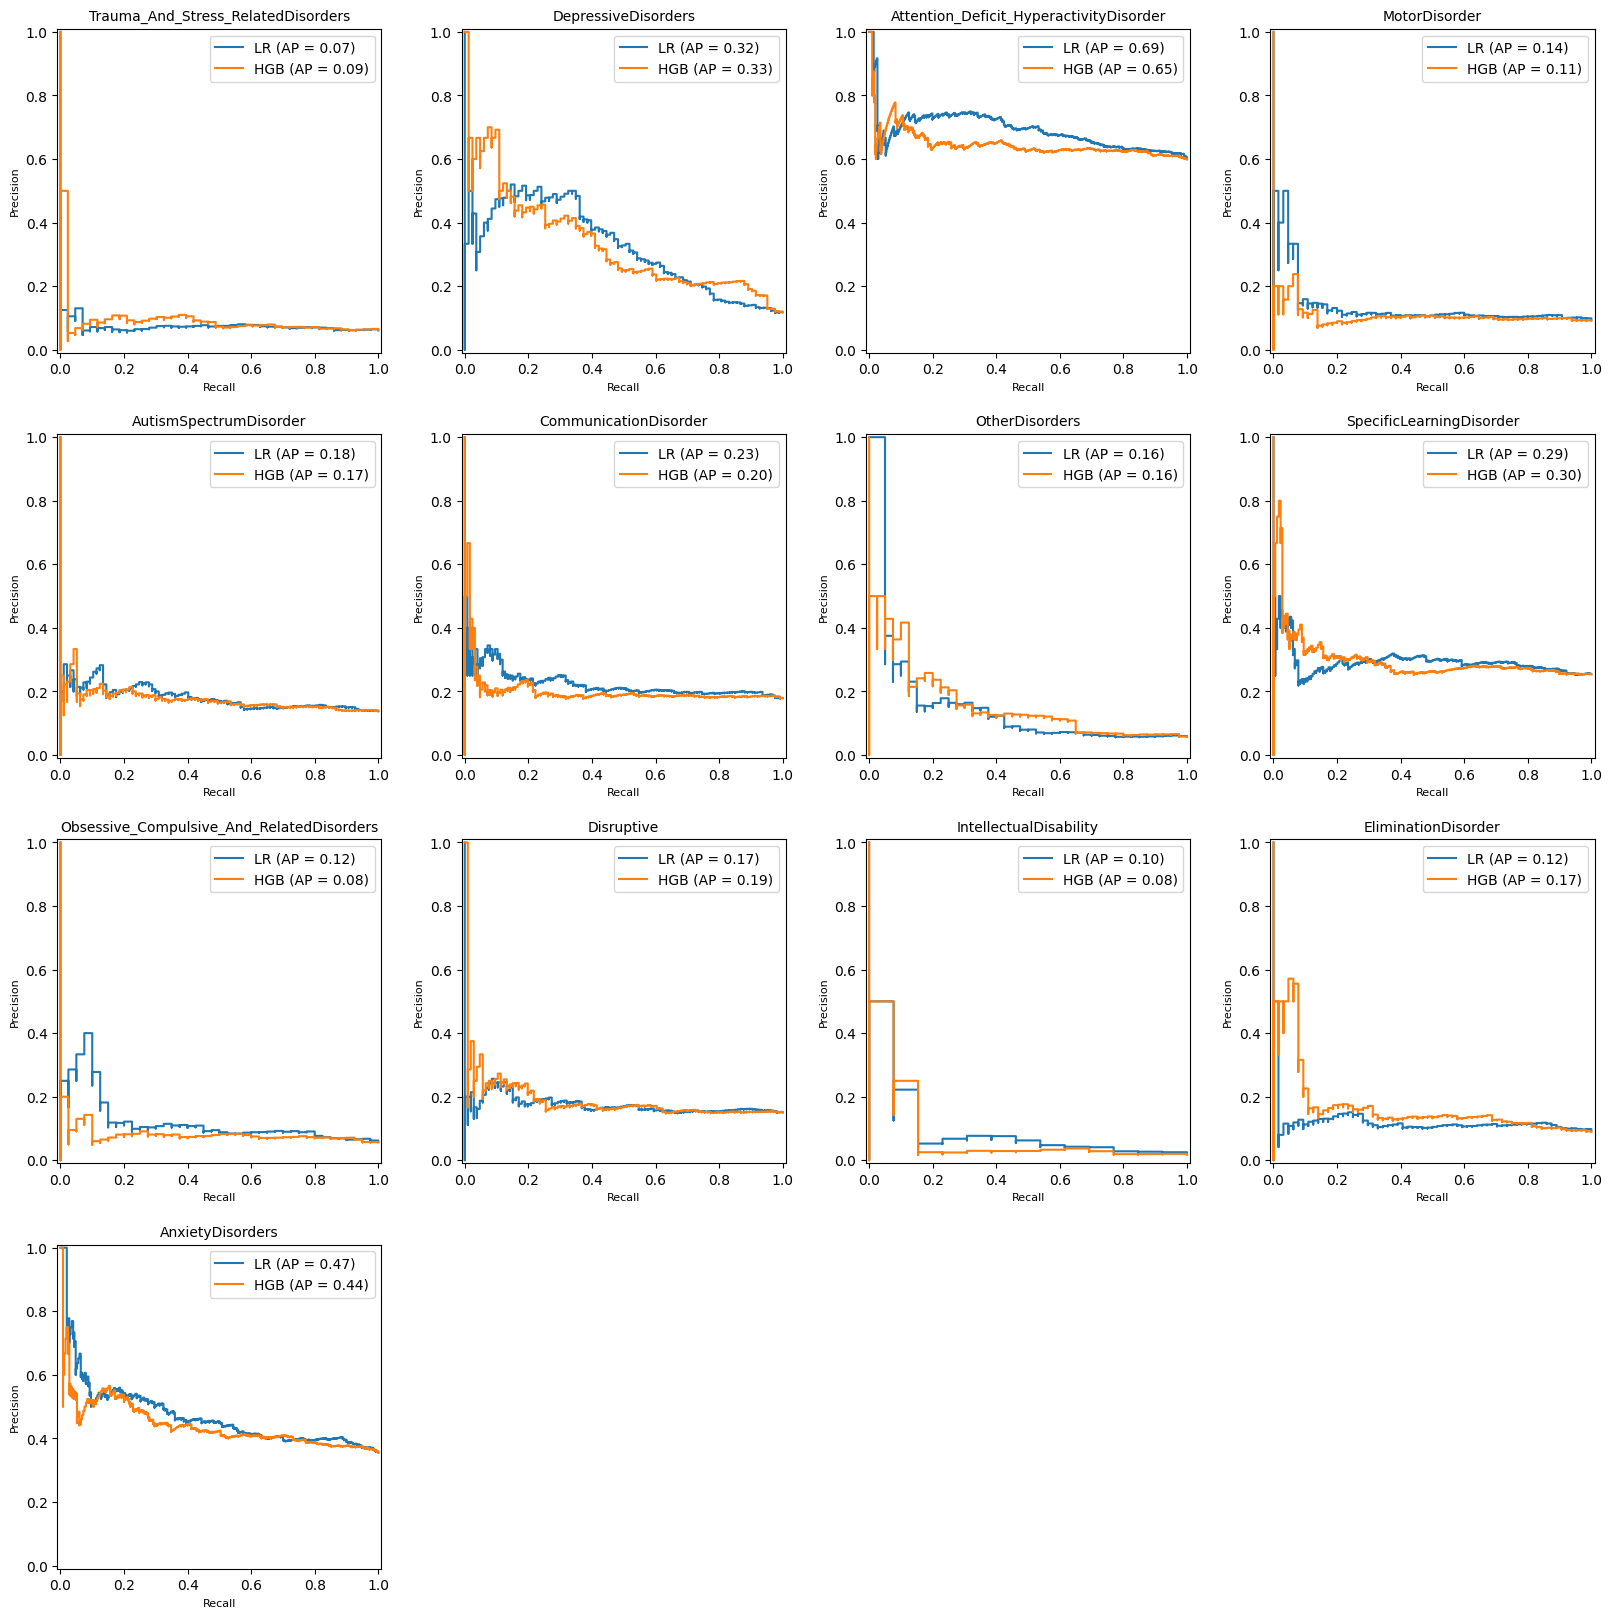

In [24]:
plot_pr_curves(X_test, Y_test, lr_1_estimators, hgb_1_estimators, 'regular')

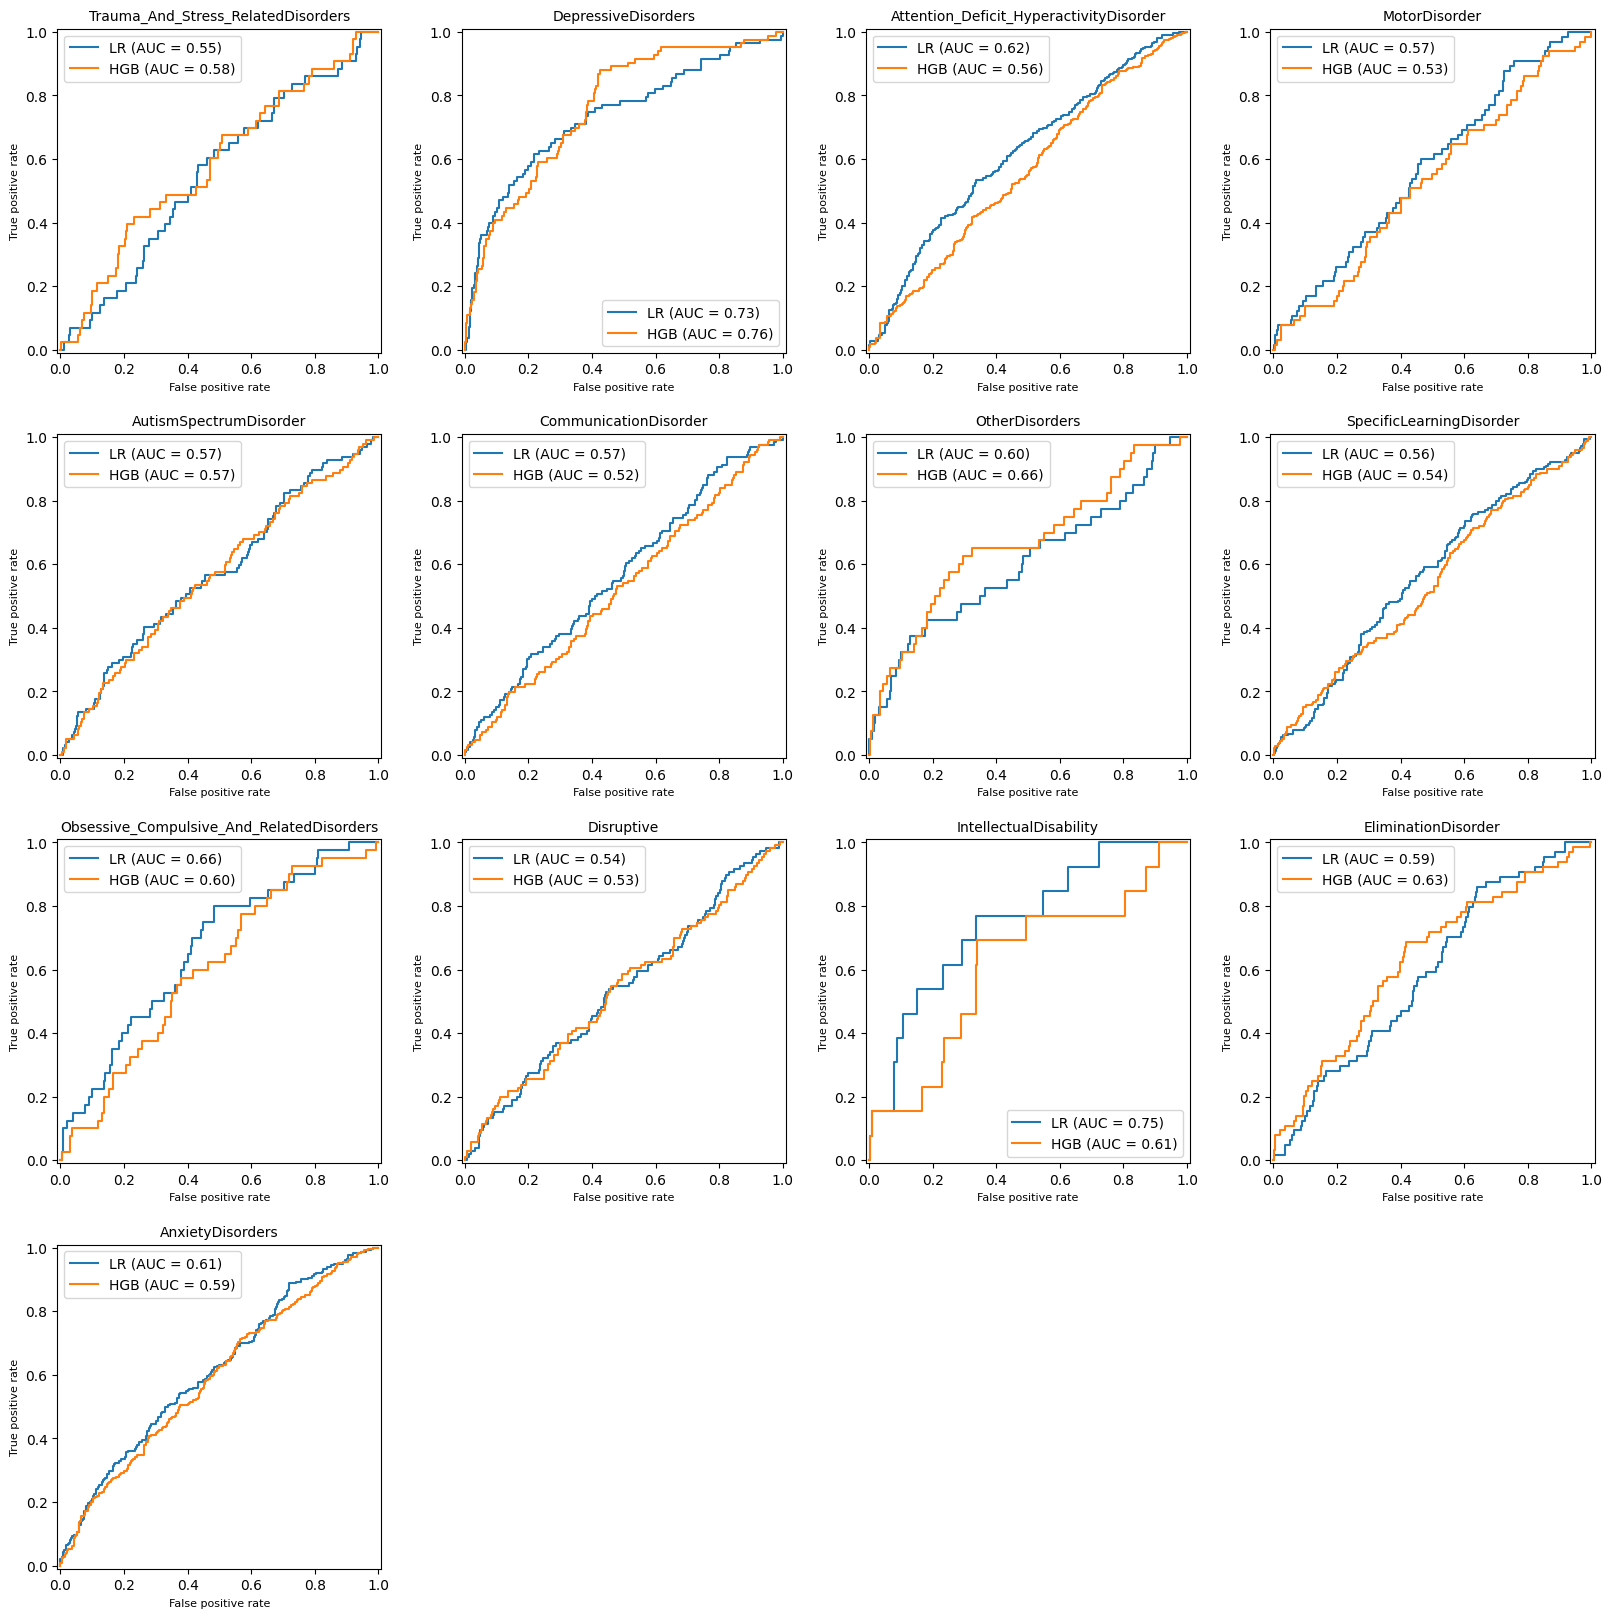

In [25]:
plot_roc_curves(X_test, Y_test, lr_1_estimators, hgb_1_estimators, 'regular')